#IMPORTING THE MODEL

In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


in this example we will use inceptionV3, a pretrained model avaiable with Keras

In [0]:
model = InceptionV3()

96116736/96112376 [==============================] - 3s 0us/step


#IMPORTING PICTURES

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


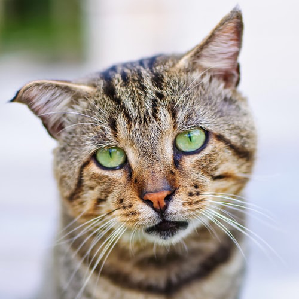

In [0]:
image_cat=load_img('/content/gdrive/My Drive/ML/PHOTOS/cat_one.jfif',target_size=(299,299))
image_cat

In [0]:
import sklearn.cluster

In [0]:
# Convert to numpy array, reshape and preprocess
image = img_to_array(image_cat)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
image[0].shape

(299, 299, 3)

In [0]:
predictions = model.predict(image)

#LIME

In [0]:
#function of keras, allows to see the prob of each prediction
decode_predictions(predictions)

40960/35363 [==================================] - 0s 0us/step


[[('n02123159', 'tiger_cat', 0.7986762),
  ('n02123045', 'tabby', 0.10207491),
  ('n02124075', 'Egyptian_cat', 0.05133065),
  ('n02127052', 'lynx', 0.0007305202),
  ('n04040759', 'radiator', 0.0004617318)]]

LIME needs the indices of the class we are interested in. The cell bellow serve to get the indices corresponding to the 5 most probably classes we predicted above. Those indices correspond to the classes used in the ImageNet dataset that was used to train our model.

In [0]:
model.predict(image).argsort()[0, -5:][::-1]

array([282, 281, 285, 287, 753])

In [0]:
!pip install lime

In [0]:
from lime.lime_image import LimeImageExplainer

In [0]:
explainer = LimeImageExplainer()

we call explain_instance to generate a new explanation. We need to provide:

our observation: here the first row of our numpy matrix (that has only one row since we only have one image)

our predict function, we can simply use the one from our model here
top_labels the number of classes to explain. Here our model generate probabilities for more than a 1000 classes (and we looked at the five first). 

We do not want LIME to generate local models to explain each of those classes. As lime is pretty slow with images, let's only ask for the explanation to our two main classes, 


num_samples: the number of new datapoints to create to fit a linear model, let's set it to 1000

In [0]:
explanation = explainer.explain_instance(image[0], #the image
                                         model.predict, 
                                         top_labels=2, #want just to see the 2 main classes predicted
                                         num_samples=5000, # number of observation sampled from the original distribution in order to computer the linear regression
                                         random_seed=42)

In [0]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

explanation.get_image_and_mask() allows to take and plot the maps.


index of the class to explain (that we discovered before) 


positive_only: In order to show the part of the image that contribute positively to this class being selected


num_features: number of superpixels to use. LIME breaks down our image into a set of superpixels, each containing several pixels. Those superpixels are equivalent to features in tabular data.


hide_rest: to hide the rest of the image


That returns a new image and a mask as numpy arrays. You can then use mark_boundaries to show the image together with the mask.

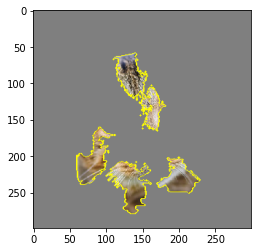

In [0]:
# maps for the first class predicted
temp, mask = explanation.get_image_and_mask(282, positive_only=True, num_features=5, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

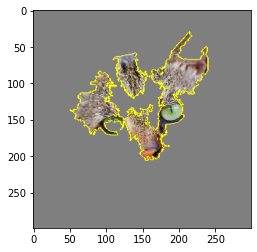

In [0]:
# maps for the second class predicted 
temp, mask = explanation.get_image_and_mask(281, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#SALIENCY MAPS

##static saliency##

This static saliency detector operates on the log-spectrum of an image, computes saliency residuals in this spectrum, and then maps the corresponding salient locations back to the spatial domain

there are 2 algorithms for static saliency.the first one is the one proposed in https://www.sciencedirect.com/science/article/abs/pii/S0262885609001371

In [0]:
import cv2
from google.colab.patches import cv2_imshow

In [0]:
image_saliency=img_to_array(image_cat)

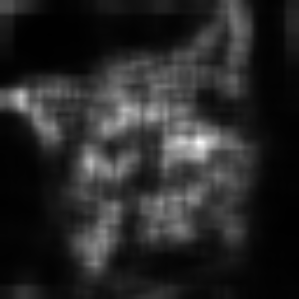

In [0]:
saliency_one = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap_one) = saliency_one.computeSaliency(image_saliency)  #the result is grayscale floating [0,1]
saliencyMap_one= (saliencyMap_one*255).astype("uint8")
cv2_imshow(saliencyMap_one)

#plt.imshow(saliencyMap)

the second is the fine grained

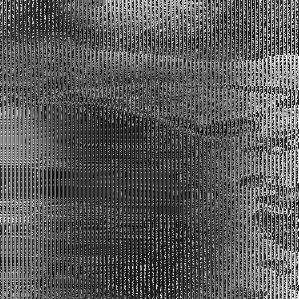

In [0]:
saliency_two = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap_two) = saliency_two.computeSaliency(image_saliency) #value already scaled 
saliencyMap_two= (saliencyMap_two*255).astype('uint8')

cv2_imshow(saliencyMap_two)

#OCCLUSION MAPS

In [0]:
import numpy as np

In [0]:
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32) #create a matrix 5 * size x 5 * size of 0.5
    occlusion_center = np.full((size, size, 1), [0.5], np.float32) #matrix size x size
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ((occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0)), 'constant', constant_values = 0.0)
    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):
        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()
            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] = occlusion
            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center
            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

In [0]:
import matplotlib.patches as patches
# Create figure and axes

def iter_occlusion(image):
  image_array=img_to_array(image)
  n=3
  dim1=image_array.shape[0]/n
  dim2=image_array.shape[1]/n
  position = list(range(0,n))
  for j in position:
    for i in position:
      fig,ax = plt.subplots()
      ax.imshow(image)
      rect = patches.Rectangle((i*dim1,j*dim2),dim1,dim2,linewidth=1,edgecolor='gray',facecolor='gray')
      ax.add_patch(rect)
      plt.show()


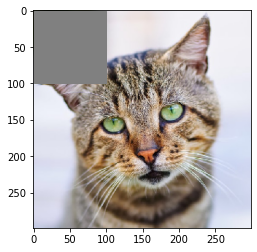

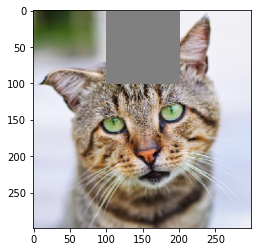

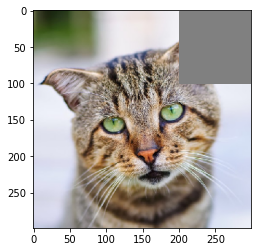

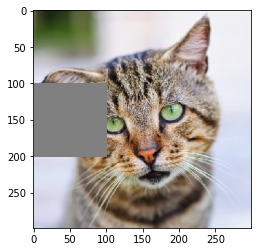

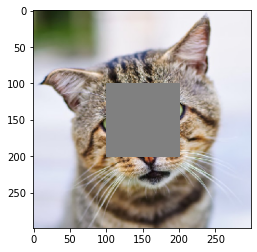

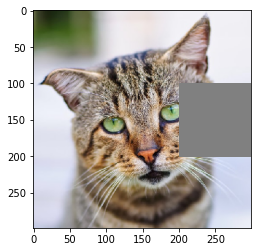

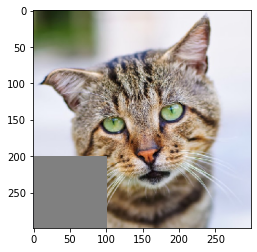

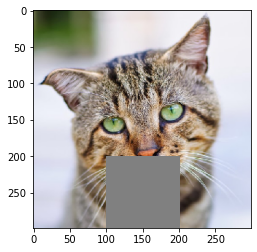

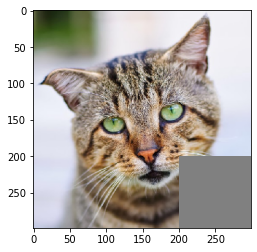

In [0]:
iter_occlusion(image_cat)